# Crypto Bot Analysis
**Author:** Tom Nguyen

**CITS4404 AI and Adaptive Systems**

## Overview

This jupypter notebook report documents the evaluation of a nature-inspired crypto trading bot. The bot operates on historical BTC price data and leverages crossover-based strategies tuned via several stochastic optimizers. The purpose of this analysis is to identify the most effective optimizer configuration that leads to profitable trading behavior.

## 1. Data Loading and Preperation

We begin by loading historical Bitcoin price data from a CSV file. The dataset contains daily closing prices, which we parse with timestamps. For modeling purposes, we split the data into training and test sets using a cutoff date of **2019-12-31**.

- The **training set** is used by the optimizers to search for profitable trading strategies.
- The **test set** represents unseen data used to evaluate generalization performance.

Only the closing price is used for strategy evaluation, aligned with the assumption that trades are based on end-of-day signals.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import core.bot as bot
import ast
import os
import ast
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import plotly.express as px

In [2]:
CSV_PATH = "data/BTC-Daily.csv"      # e.g. 'data/BTC-Daily.csv'
DATE_COL = "date"                    # 'date' in some files
CLOSE_COL = "close"                  # 'close' in some files
TRAIN_TO = "2019-12-31"

# --- Load & split ---
df = pd.read_csv(CSV_PATH, parse_dates=[DATE_COL])
price_all = df[CLOSE_COL].to_numpy()
train_mask = df[DATE_COL] <= TRAIN_TO
prices_train = price_all[train_mask]
prices_test  = price_all[~train_mask]
dates_test  = df.loc[~train_mask, DATE_COL].to_numpy()


### 1.1 Loading and Filtering Optimizer Results

After completing multiple runs for each optimizer, we load the saved result files from disk. Each file contains metrics from a different configuration or random seed.

We apply the following steps:

1. **Aggregate results** from all CSVs in the `results` folder.
2. **Sort** results by test set performance (`test` column).
3. **Select the top 200 runs per optimizer** for deeper comparison and analysis.
4. **Identify the best configuration per optimizer**, based on the lowest test error.

This ensures that we are comparing only the most promising configurations from each algorithm.


In [3]:
def load_top_results_per_algo(folder_path, sort_by="test", top_n=100):
    """
    Load all result CSV files from a folder and return the top-N performing results per algorithm.

    Parameters:
        folder_path (str): Path to the folder containing result CSV files.
        sort_by (str): Column name to sort by (default: 'test').
        top_n (int): Number of top rows to return per algorithm (default: 10).

    Returns:
        pd.DataFrame: Top-N rows per algorithm, sorted by `sort_by` metric.
    """
    all_results = []

    for file in os.listdir(folder_path):
        if file.endswith(".csv"):
            file_path = os.path.join(folder_path, file)
            df = pd.read_csv(file_path)

            # Parse theta column if present
            for col in df.columns:
                if "theta" in col and "parsed" not in col:
                    df["theta_parsed"] = df[col].apply(ast.literal_eval)
                    break

            all_results.append(df)

    if not all_results:
        raise ValueError("No CSV files found in the specified folder.")

    full_df = pd.concat(all_results, ignore_index=True)

    # Top-N results per algorithm
    top_per_alg = (
        full_df.sort_values(by=sort_by, ascending=True)  # lower is better if it's loss
        .groupby("alg")
        .head(top_n)
        .reset_index(drop=True)
    )

    return top_per_alg


def get_best_configurations_per_algo(df, score_col="test", group_col="alg"):
    """
    Return the best-performing configuration for each algorithm based on the lowest test score.

    Parameters:
        df (pd.DataFrame): DataFrame containing results with at least 'alg' and 'test' columns.
        score_col (str): Column name to minimize for selecting best result (default: 'test').
        group_col (str): Column name to group by (default: 'alg').

    Returns:
        pd.DataFrame: Filtered DataFrame with one row per algorithm — the best config.
    """
    idx_best = df.groupby(group_col)[score_col].idxmin()
    return df.loc[idx_best].reset_index(drop=True)

In [4]:
RESULTS_FOLDER = "./results"  # Path to the folder containing result CSV files

best_df = load_top_results_per_algo(RESULTS_FOLDER, sort_by="test", top_n=200)

best_algos_df = get_best_configurations_per_algo(best_df, score_col="test", group_col="alg")

In [5]:
# Best 200 results for each algorithm
best_df.head(10)


,alg,seed,train,test,theta,pop_size,gens,stalled_gens,tolerance,patience,fitness_history,time(seconds),theta_parsed
0,CAB,2891,-47539.072668,-9809.076538,"[3.7496667813184064, 0.9910610154449132, 0.353...",50,15,10,0.0001,10,"[-42334.35097707562, -42334.35097707562, -4233...",1.63,"[3.7496667813184064, 0.9910610154449132, 0.353..."
1,CAB,2891,-47539.072668,-9809.076538,"[3.7496667813184064, 0.9910610154449132, 0.353...",50,15,10,0.0001,10,"[-42334.35097707562, -42334.35097707562, -4233...",1.58,"[3.7496667813184064, 0.9910610154449132, 0.353..."
2,CAB,2061,-45458.982562,-9780.814838,"[4.063520244457197, 1.3718954725029857, 0.3978...",50,13,10,0.0001,10,"[-38279.47573094408, -38279.47573094408, -4545...",1.34,"[4.063520244457197, 1.3718954725029857, 0.3978..."
3,CAB,2234,-54110.700947,-9307.325279,"[6.454433895696327, 0.38545061788625806, 0.348...",50,23,10,0.0001,10,"[-46919.80455283609, -51459.44969347354, -5145...",2.44,"[6.454433895696327, 0.38545061788625806, 0.348..."
4,CAB,29,-54110.700947,-9307.325279,"[6.035636654651473, 0.06442184033594515, 0.302...",50,11,10,0.3000,10,"[-52716.42615256251, -52716.42615256251, -5361...",3.61,"[6.035636654651473, 0.06442184033594515, 0.302..."
5,CAB,29,-54110.700947,-9307.325279,"[6.035636654651473, 0.06442184033594515, 0.302...",50,18,10,0.0001,10,"[-52716.42615256251, -53612.47038475751, -5364...",1.69,"[6.035636654651473, 0.06442184033594515, 0.302..."
6,CAB,2088,-54110.700947,-9307.325279,"[6.358779947838618, 0.16303743159356313, 0.233...",50,16,10,0.0001,10,"[-47055.32290095984, -47055.32290095984, -4705...",2.04,"[6.358779947838618, 0.16303743159356313, 0.233..."
7,GWO,3695,-61074.162727,-9148.248268,"[6.1318525243658515, 0.0, 0.05, 171.7304152782...",50,13,10,0.0001,10,"[-26480.551421269214, -50927.46540013463, -610...",0.87,"[6.1318525243658515, 0.0, 0.05, 171.7304152782..."
8,CAB,2500,-55445.595716,-9148.248268,"[6.4677510692797675, 0.34182825358982416, 0.16...",50,12,10,0.0001,10,"[-54971.30029924244, -55445.595716095006, -554...",1.27,"[6.4677510692797675, 0.34182825358982416, 0.16..."
9,CAB,3256,-59605.826874,-9148.248268,"[5.657560413119262, 0.39616563496013174, 0.074...",50,22,10,0.0001,10,"[-47833.50147411764, -47833.50147411764, -4783...",2.96,"[5.657560413119262, 0.39616563496013174, 0.074..."


In [6]:
# Best configuration for each algorithm
best_algos_df

,alg,seed,train,test,theta,pop_size,gens,stalled_gens,tolerance,patience,fitness_history,time(seconds),theta_parsed
0,ABC,3700,-62523.399028,-9090.518801,"[6.017094713469811, 1.949066275064014, 0.05025...",50,13,10,0.0001,10,"[-53107.45121438091, -59732.21149835392, -6252...",3.41,"[6.017094713469811, 1.949066275064014, 0.05025..."
1,CAB,2891,-47539.072668,-9809.076538,"[3.7496667813184064, 0.9910610154449132, 0.353...",50,15,10,0.0001,10,"[-42334.35097707562, -42334.35097707562, -4233...",1.63,"[3.7496667813184064, 0.9910610154449132, 0.353..."
2,GWO,3695,-61074.162727,-9148.248268,"[6.1318525243658515, 0.0, 0.05, 171.7304152782...",50,13,10,0.0001,10,"[-26480.551421269214, -50927.46540013463, -610...",0.87,"[6.1318525243658515, 0.0, 0.05, 171.7304152782..."
3,PSO,198,-56656.637452,-8684.058276,"[6.114961986813401, 0.0, 0.5, 171.008173309172...",50,23,10,0.0001,10,"[-19177.31785847029, -32427.55434197741, -4066...",2.25,"[6.114961986813401, 0.0, 0.5, 171.008173309172..."


## 2. Visualisation

### 2.1 Buy/Sell Signal Crossovers
To better understand how each optimizer’s best configuration performs in practice, we visualize their respective buy and sell signals on the BTC test data. The plot below overlays:

- The close price (black line)

- The fast filter signal (teal dashed line)

- The slow filter signal (orange line)

- Buy signals (green triangles)

- Sell signals (red inverted triangles)

Each subplot corresponds to the top configuration for a given optimizer. These plots provide insights into the bot's trading behavior, including entry/exit timing, signal reactivity, and how effectively it avoids false positives in volatile markets.

In [7]:
def plot_crossovers(best_df, prices_test, dates_test):
    """
    Plot close price, buy/sell signals, and indicator lines (fast/slow signals)
    for each best configuration (one subplot per run).
    
    Args:
        best_df: DataFrame with columns ['theta_parsed', 'alg', 'seed']
        prices_test: np.array of test close prices
        dates_test: np.array of corresponding dates
    """
    n = len(best_df)
    fig, axes = plt.subplots(n, 1, figsize=(12, 4 * n), sharex=True)

    if n == 1:
        axes = [axes]  # ensure axes is iterable even for n=1

    for ax, (_, row) in zip(axes, best_df.iterrows()):
        theta = row["theta_parsed"]
        d1, t1, a1, d2, t2, a2, buy_delay, sell_delay= theta

        # Get crossover signals
        buy_idx, sell_idx, tail_len = bot.crossover_signals(prices_test, theta)
        dates_tail  = dates_test[-tail_len:] 
        prices_tail = prices_test[-tail_len:]

        # Build the fast and slow moving average signals
        fast_signal = bot.make_signal(prices_test, int(d1), int(t1), a1)[-tail_len:]
        slow_signal = bot.make_signal(prices_test, int(d2), int(t2), a2)[-tail_len:]
        
        # Ensure no out-of-bounds indices
        buy_idx = buy_idx[(buy_idx >= 0) & (buy_idx < len(prices_tail))]
        sell_idx = sell_idx[(sell_idx >= 0) & (sell_idx < len(prices_tail))]

        # --- Plot
        ax.plot(dates_tail, prices_tail, label="Close Price", color="black", linewidth=1)
        ax.plot(dates_tail, slow_signal, label=f"Slow MA (d={int(d2)}) {bot.TYPE_MAP.get(int(t2))}", color="orange", linestyle="-")
        ax.plot(dates_tail, fast_signal, label=f"Fast MA (d={int(d1)}) {bot.TYPE_MAP.get(int(t1))}", color="teal", linestyle="--")

        ax.scatter(dates_tail[buy_idx],  prices_tail[buy_idx],
                   marker="^", color="green", s=80, label="Buy Signal")
        ax.scatter(dates_tail[sell_idx], prices_tail[sell_idx],
                   marker="v", color="red",   s=80, label="Sell Signal")

        ax.set_title(f"{row['alg']} Crossover (Seed {row['seed']} | Starting + Profit: ${-1 * row["test"]:.2f})", fontsize=12)
        ax.legend(loc="upper left")

    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

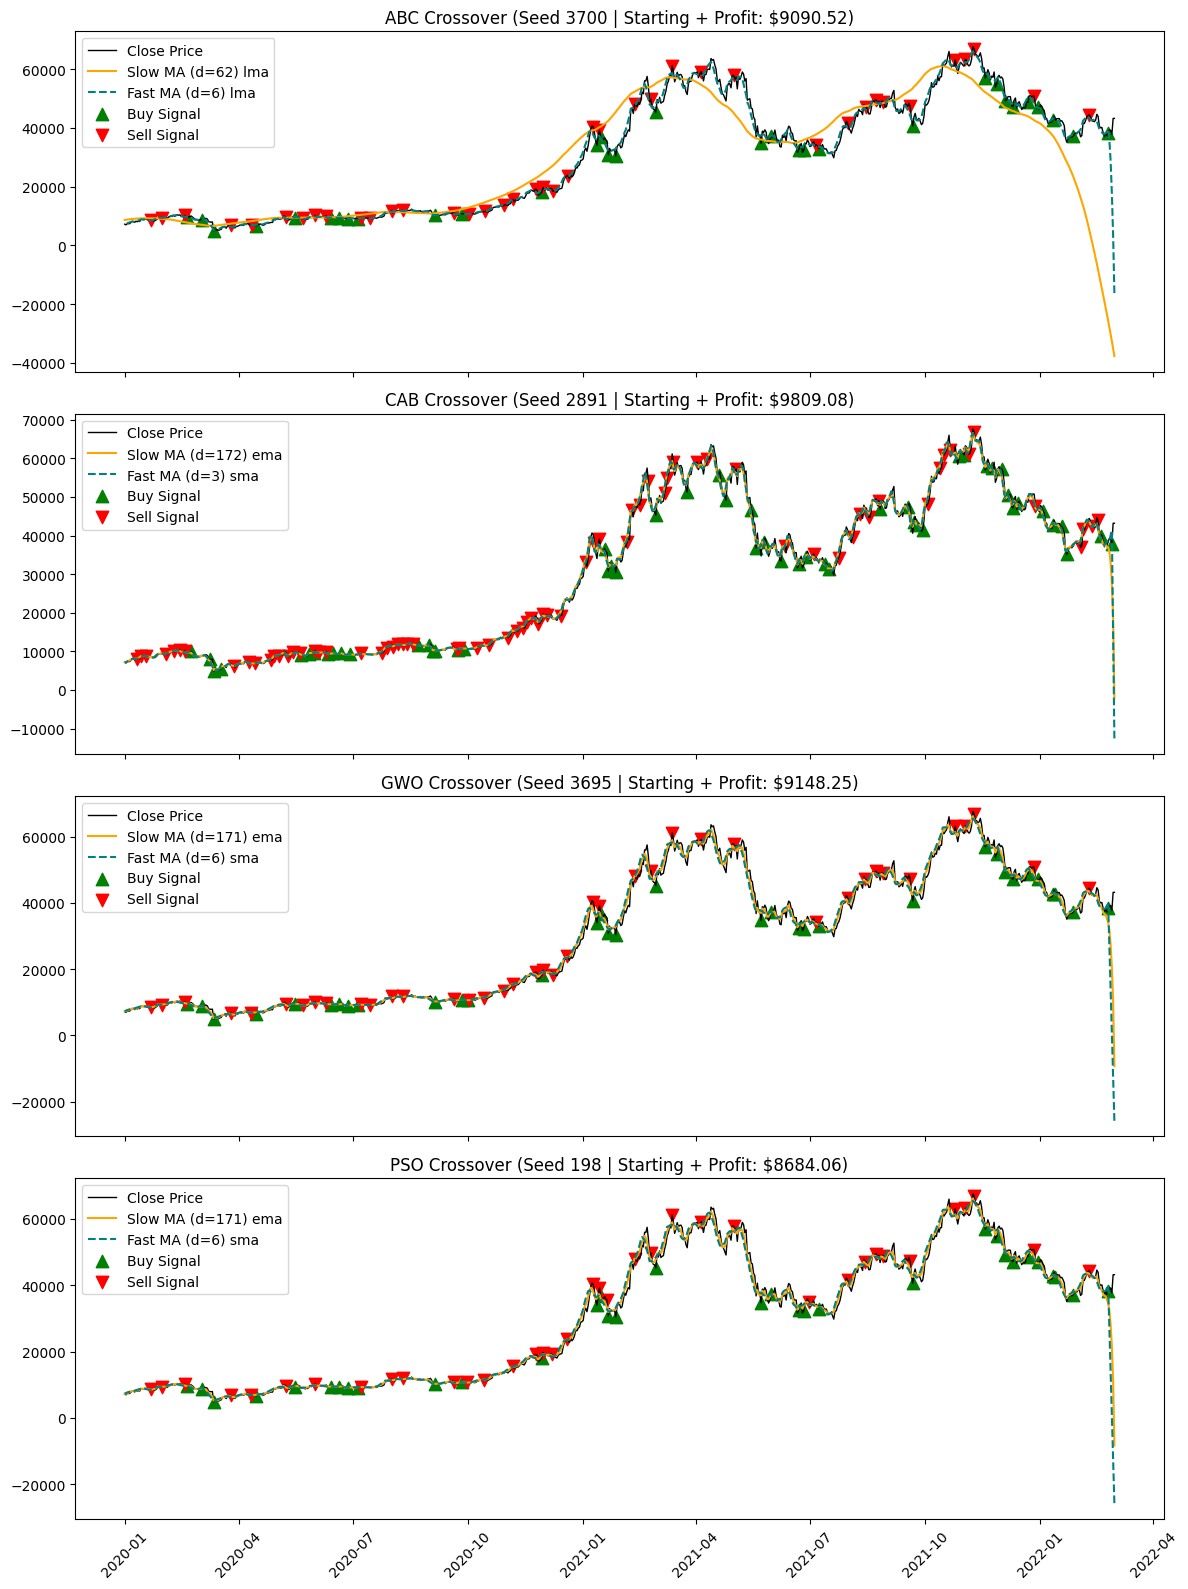

In [8]:
plot_crossovers(best_algos_df, prices_test, dates_test)

## 

### 2.2 Fitness vs Generation

To better understand and compare the effectiveness of different optimisation algorithms on our trading strategy, we present several key visualisations:

1. Test Fitness Distribution

    This plot compares the distribution of test set performance (test fitness score) across the top configurations for each algorithm. Lower values are better, as the fitness function reflects the negative of final USD holdings.

    - 📦 Boxplot shows the spread (IQR) of fitness scores

    - 🎯 Stripplot overlays individual runs for transparency

    - ✅ Helps identify consistency and outliers per algorithm

2. Generation Counts

    This shows how many generations were needed before early stopping criteria were met. Lower generation counts suggest the optimiser converged quickly.

    - 📉 Useful for assessing algorithm efficiency

    - 🔍 Reveals whether some algorithms hit the maximum generation cap (GENS)

3. Fitness vs Generations Scatter Plot

    This scatter plot compares each run's test fitness against the number of generations it ran before stopping.

    - 🔄 Tradeoff between optimization effort and outcome

    - 🎨 Color-coded by algorithm for easy comparison

    - 📌 Helps visualize diminishing returns from additional generations

    You can configure the number of top results plotted per algorithm using a parameter (e.g., top_k_per_algo = 50) to reduce visual clutter in the charts.

In [9]:
def compare_test_fitness(top_df):
    """
    Compare test fitness across algorithms using boxplot and stripplot.

    Parameters:
        top_df (pd.DataFrame): DataFrame of top-N results per algorithm.
    """
    metric = "test"

    if metric not in top_df.columns:
        raise ValueError(f"Metric '{metric}' not found in DataFrame.")

    plt.figure(figsize=(10, 6))
    sns.boxplot(x="alg", y=metric, hue="alg", data=top_df, palette="Set2", showfliers=False, legend=False)
    sns.stripplot(x="alg", y=metric, data=top_df, color="black", size=5, jitter=True, alpha=0.7)

    n = top_df["alg"].value_counts().iloc[0]
    plt.title(f"Top {n} Test Fitness Distribution per Algorithm")
    plt.ylabel("Test Fitness")
    plt.xlabel("Algorithm")
    plt.grid(True, axis="y", linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()

def plot_gens_boxplot_with_strip(df):
    """
    Create a boxplot + stripplot of generation counts per algorithm.

    Parameters:
        df (pd.DataFrame): Must include 'alg' and 'gens' columns,
                           ideally multiple entries per algorithm (e.g., top 10).
    """
    if not {"alg", "gens"}.issubset(df.columns):
        raise ValueError("DataFrame must contain 'alg' and 'gens' columns.")

    plt.figure(figsize=(10, 6))
    sns.boxplot(x="alg", y="gens", hue="alg", data=df, palette="Set2", showfliers=False, legend=False)
    sns.stripplot(x="alg", y="gens", data=df, color="black", size=5, jitter=True, alpha=0.7)

    plt.title("Distribution of Generation Counts per Algorithm")
    plt.xlabel("Algorithm")
    plt.ylabel("Generations")
    plt.grid(axis='y', linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()

def plot_fitness_vs_generations_interactive(df, fitness_col="test", max_per_algo=30):
    """
    Interactive scatter plot of fitness vs generations using Plotly,
    with hover tooltips showing algorithm, fitness, gens, and seed.

    Parameters:
        df (pd.DataFrame): Must contain 'alg', 'gens', 'seed' and the fitness column.
        fitness_col (str): Fitness column to plot on the Y-axis.
        max_per_algo (int): Max number of points to show per algorithm.
    """
    required_cols = {"alg", "gens", "seed", fitness_col}
    if not required_cols.issubset(df.columns):
        raise ValueError(f"DataFrame must include: {required_cols}")

    # Limit to top-N per algorithm
    limited_df = (
        df.sort_values(by=fitness_col)
          .groupby("alg")
          .head(max_per_algo)
          .reset_index(drop=True)
    )

    fig = px.scatter(
        limited_df,
        x="gens",
        y=fitness_col,
        color="alg",
        symbol="alg",
        hover_data=["alg", "seed", "gens", fitness_col, "theta"],
        title=f"{fitness_col.capitalize()} Fitness vs Generations",
        labels={"gens": "Generations", fitness_col: f"{fitness_col.capitalize()} Fitness"},
        template="plotly_white"
    )

    fig.update_traces(marker=dict(size=10, opacity=0.8))
    fig.update_layout(legend_title_text="Algorithm")
    fig.show()


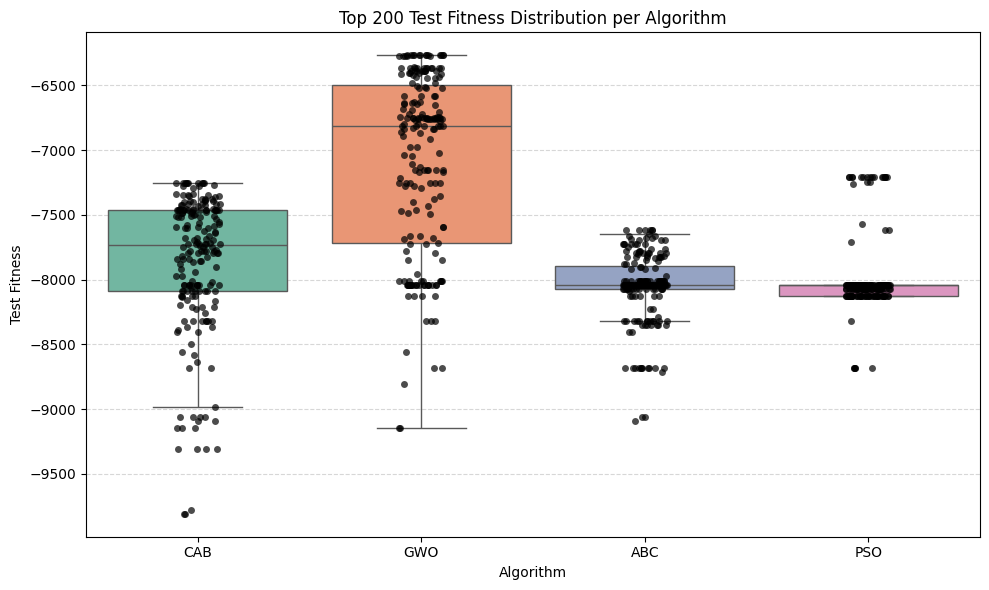

In [10]:
# 2.2.1. Test Fitness Distribution
compare_test_fitness(best_df)

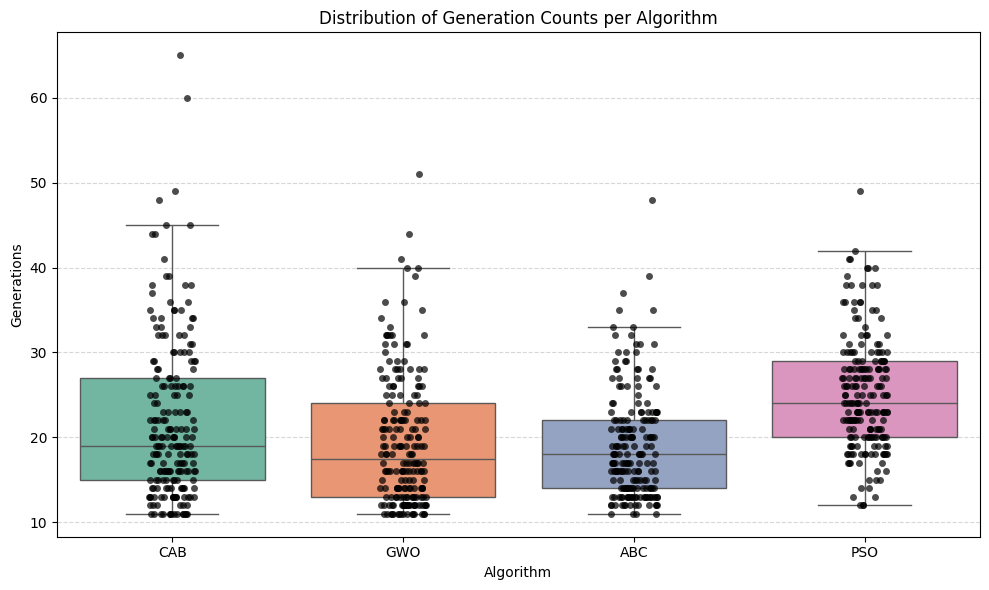

In [11]:
# 2.2.2. Generation Counts
plot_gens_boxplot_with_strip(best_df)

In [12]:
# 2.2.3. Fitness vs Generations Scatter Plot
plot_fitness_vs_generations_interactive(best_df, fitness_col="test")

### 2.3 Bot Hyperparameter Distribution

This section explores the distribution of optimised bot configuration parameters (theta) across the top-performing results. Each parameter controls a different aspect of the crossover strategy:

- `d1 / d2`: Window sizes for the fast and slow moving averages.

- `t1 / t2`: Type of moving average (0=SMA, 1=LMA, 2=EMA, 3=MACD).

- `a1 / a2`: Smoothing factor for exponential MAs (only used when type=EMA).

- `Buy Delay / Sell Delay`: Number of days to delay execution after a signal.

By visualizing these distributions, we can identify common trends in effective configurations. For example:

- A clustering of `t1` around 2 might suggest that EMA is a more reliable fast signal.

- Narrow ranges in `d2` could imply consistent slow MA settings across top performers.

- Higher values for `Buy Delay` might reduce false positives by delaying entry until signals are confirmed.

These plots provide valuable insights into which parameter combinations are consistently favored by the optimizers and help guide future tuning or rule-based strategy design.

In [13]:
def plot_theta_distribution(df, theta_col="theta_parsed", alg_filter=None):
    """
    Visualize the distribution of each trading strategy hyperparameter (theta) across experiments.

    Parameters:
        df (pd.DataFrame): Must include a parsed theta column (list of 8 floats).
        theta_col (str): Column name containing the parsed theta lists.
        alg_filter (str or list of str, optional): Filter results to specific algorithm(s).
    """
    algo_name = "All"
    # Apply algorithm filtering if needed
    if alg_filter is not None:
        alg_filter = [alg_filter] if isinstance(alg_filter, str) else alg_filter
        df = df[df["alg"].isin(alg_filter)]
        algo_name = alg_filter[0]

    # Define labels for each theta parameter
    theta_labels = [
        "d1 (Fast MA Window)",
        "t1 (Fast MA Type)",
        "a1 (Fast Alpha)",
        "d2 (Slow MA Window)",
        "t2 (Slow MA Type)",
        "a2 (Slow Alpha)",
        "Buy Delay",
        "Sell Delay"
    ]

    # Extract and round relevant theta entries
    theta_array = np.vstack(df[theta_col].values)
    theta_array = theta_array.astype(float)

    # Round integer-like parameters
    int_indices = [0, 1, 3, 4, 6, 7]
    theta_array[:, int_indices] = np.round(theta_array[:, int_indices])

    # Setup plotting grid
    n_params = theta_array.shape[1]
    n_cols = 3
    n_rows = (n_params + n_cols - 1) // n_cols

    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(16, 4 * n_rows))
    axes = axes.flatten()

    for i in range(n_params):
        label = theta_labels[i] if i < len(theta_labels) else f"Theta[{i}]"
        sns.histplot(theta_array[:, i], bins=20, kde=True, ax=axes[i],
                     color="cornflowerblue", edgecolor="black")
        axes[i].set_title(f"{label} Distribution")
        axes[i].set_xlabel(label)
        axes[i].set_ylabel("Frequency")

    # Remove unused subplots
    for j in range(n_params, len(axes)):
        axes[j].axis("off")

    plt.suptitle(f"{algo_name} Distribution of Optimized Bot Hyperparameters", fontsize=18)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


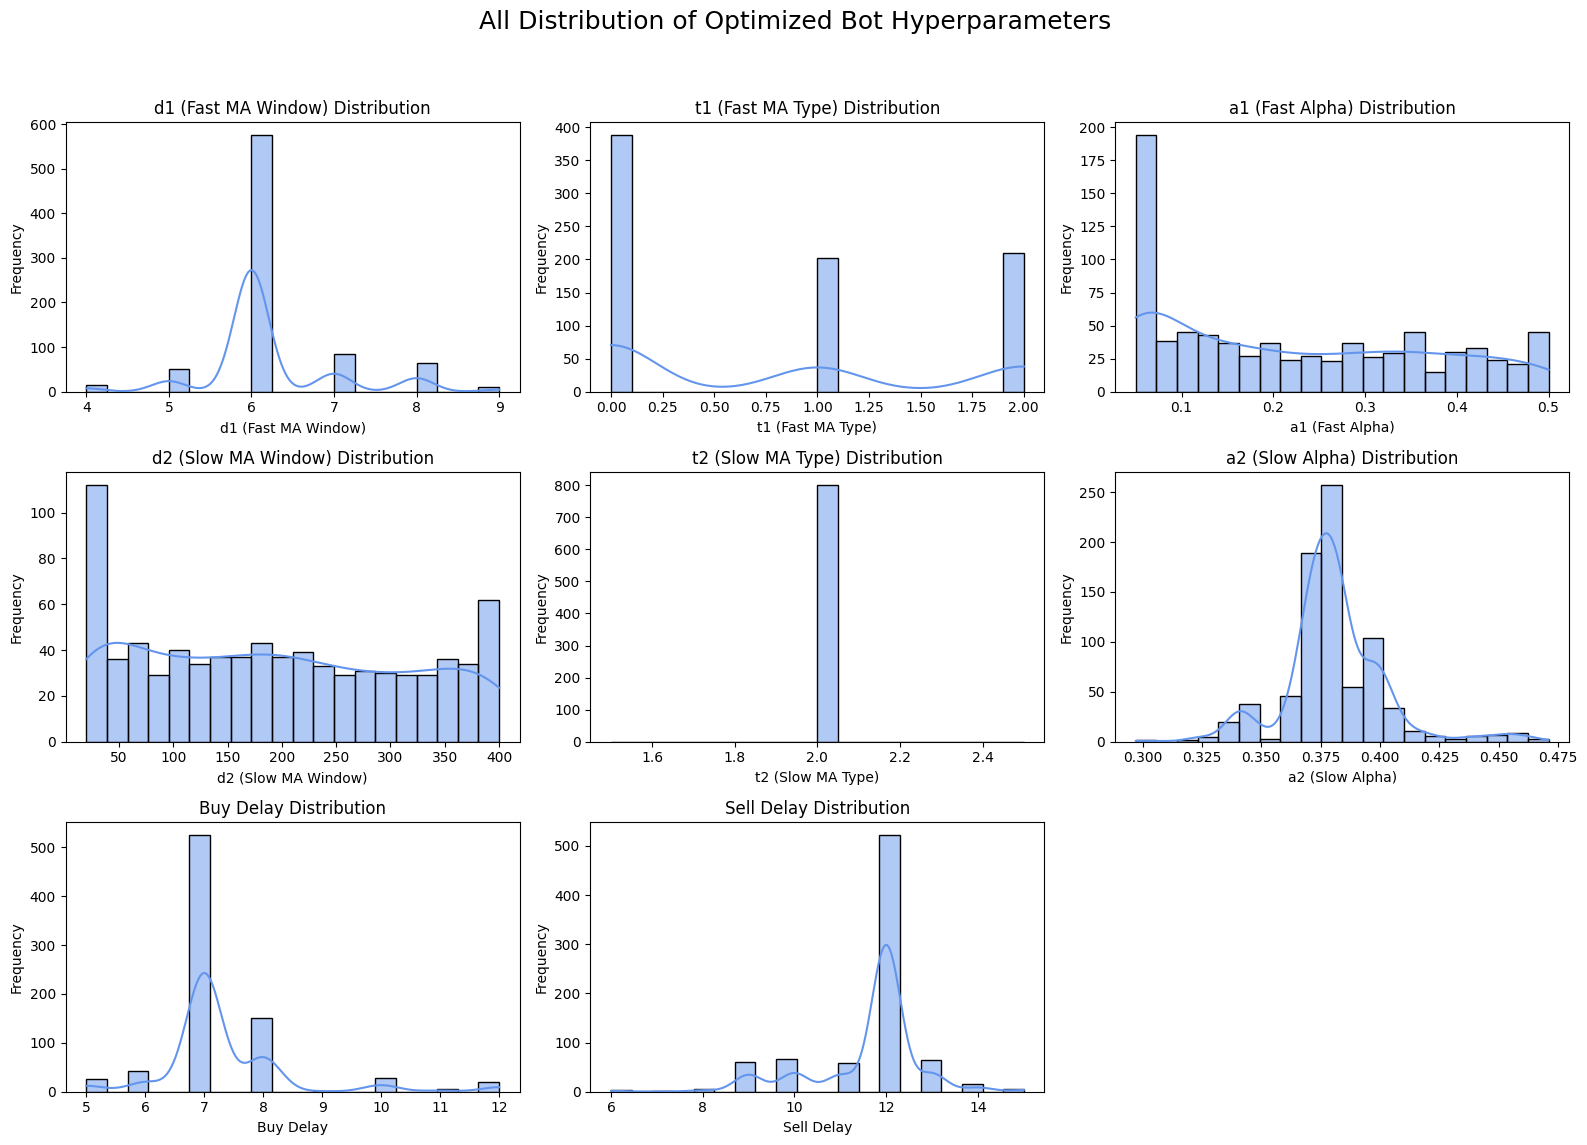

In [14]:
plot_theta_distribution(best_df)

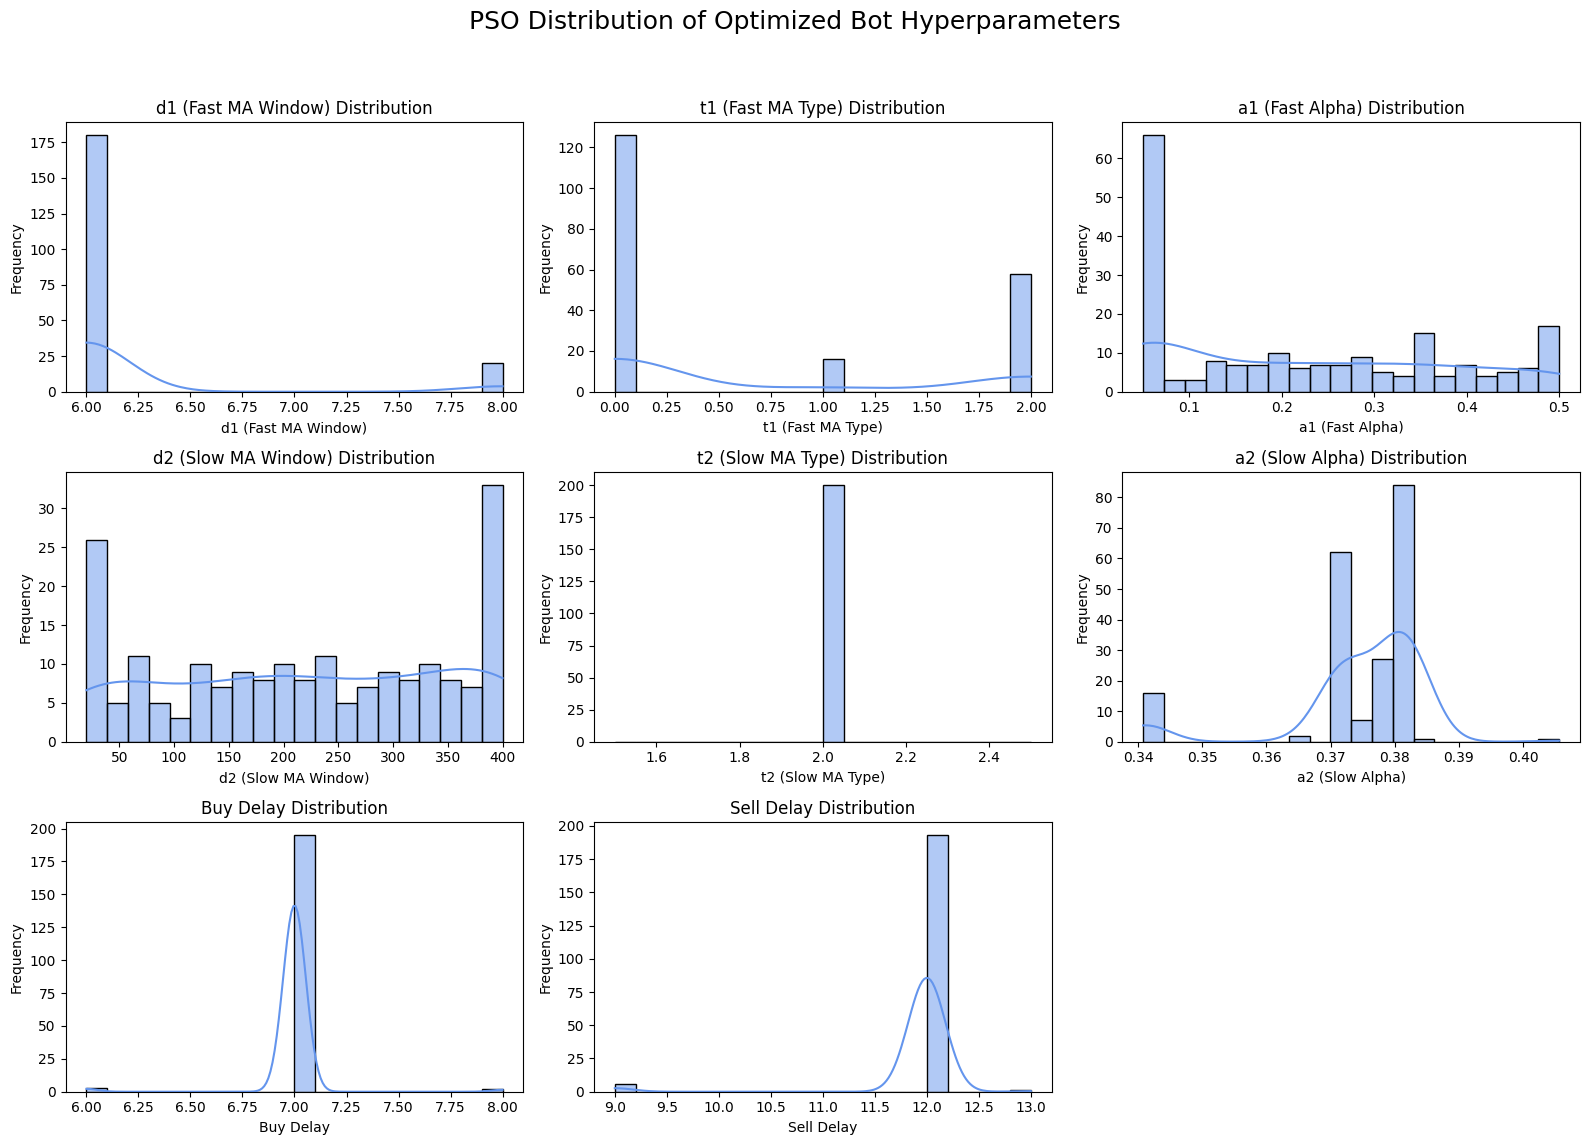

In [15]:
plot_theta_distribution(best_df, alg_filter="PSO")

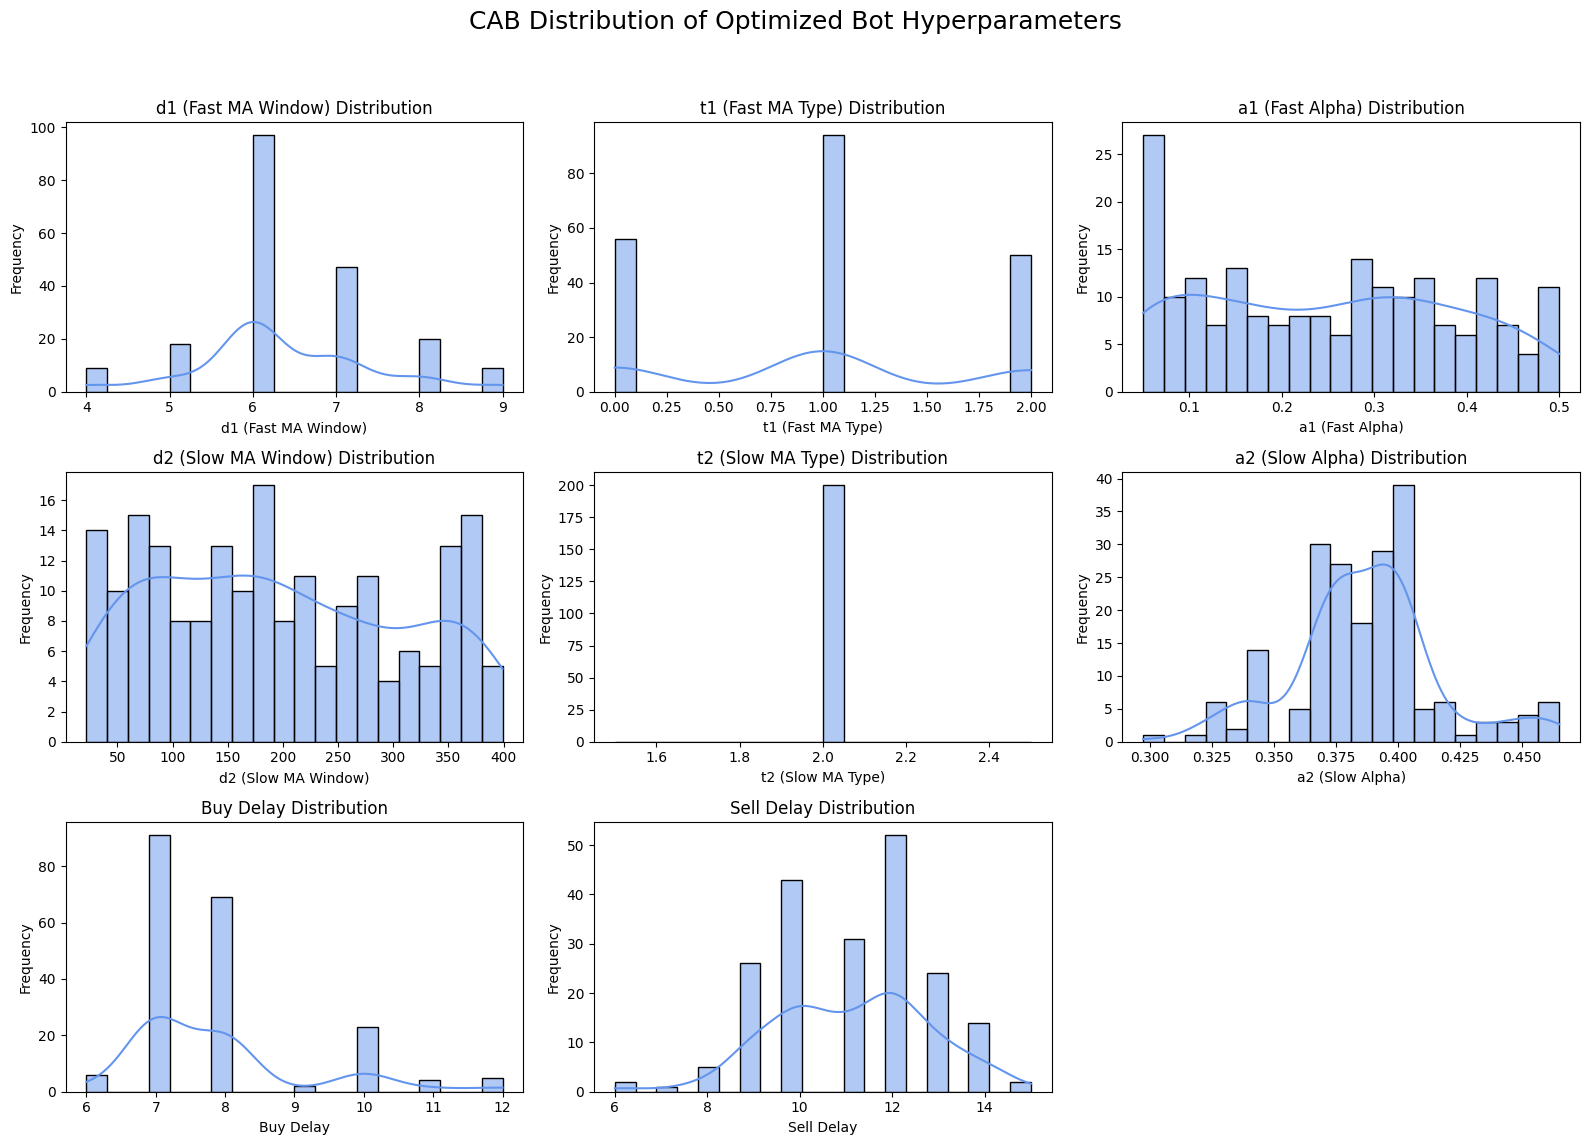

In [16]:
plot_theta_distribution(best_df, alg_filter="CAB")

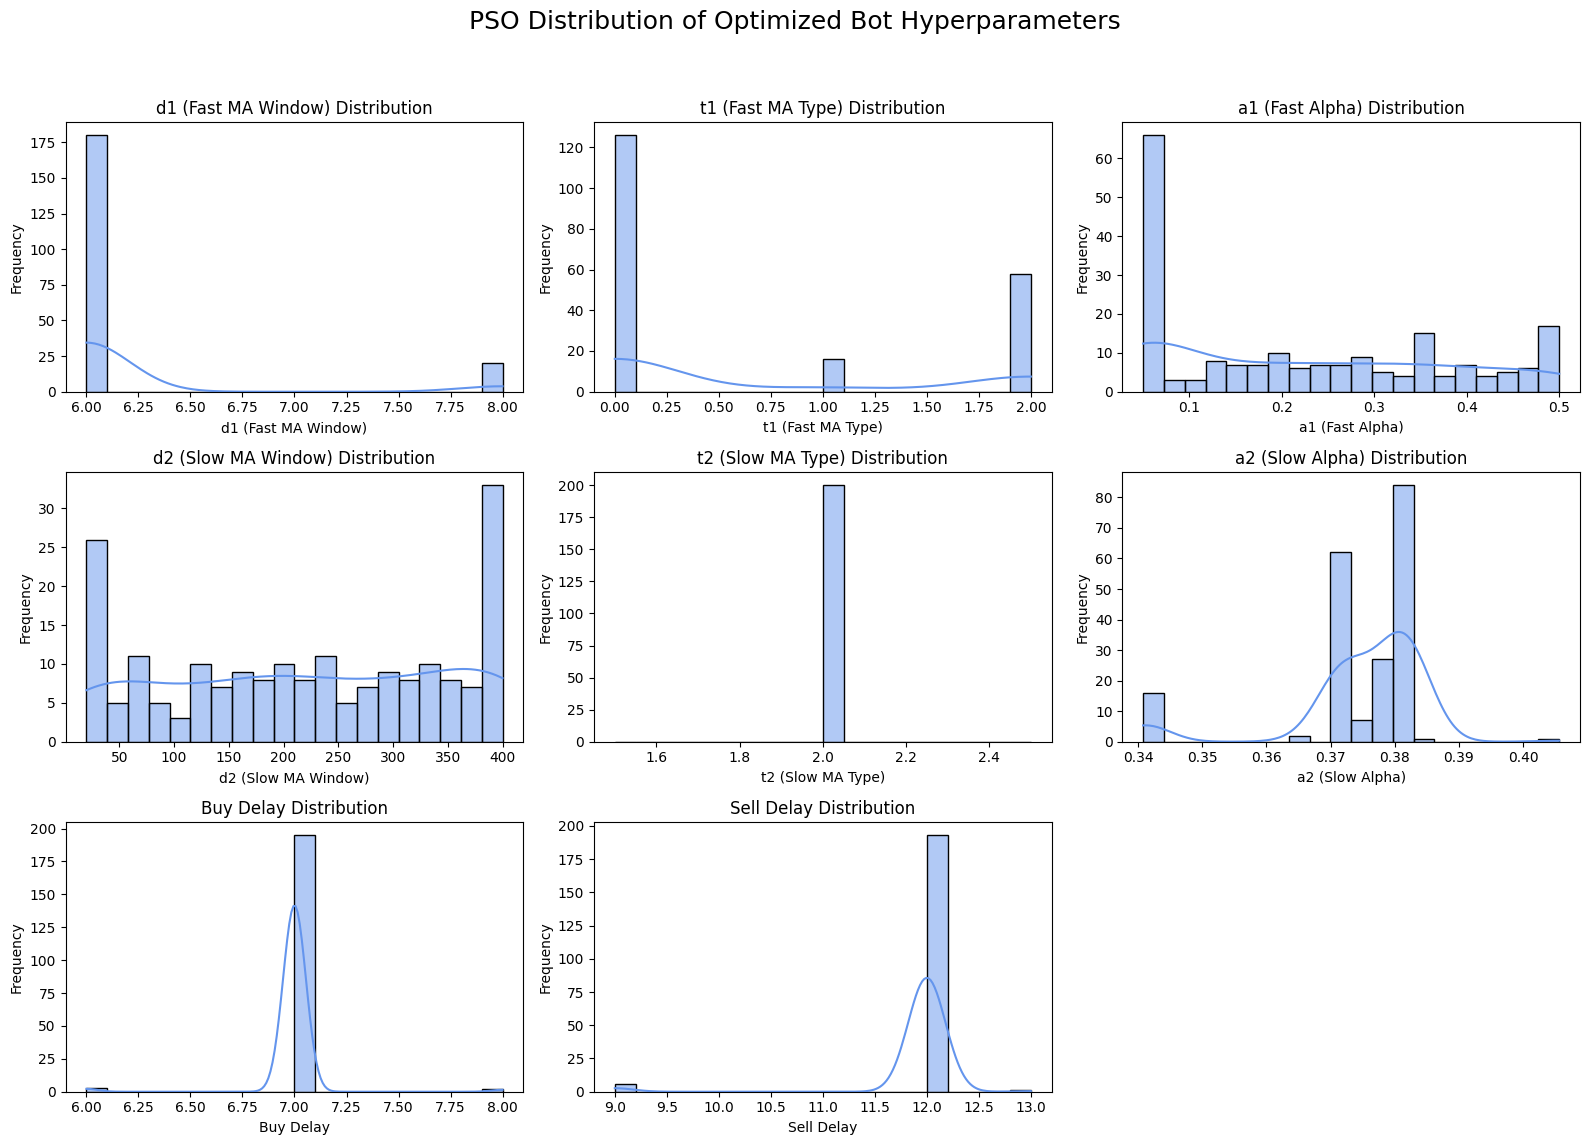

In [17]:
plot_theta_distribution(best_df, alg_filter="PSO")

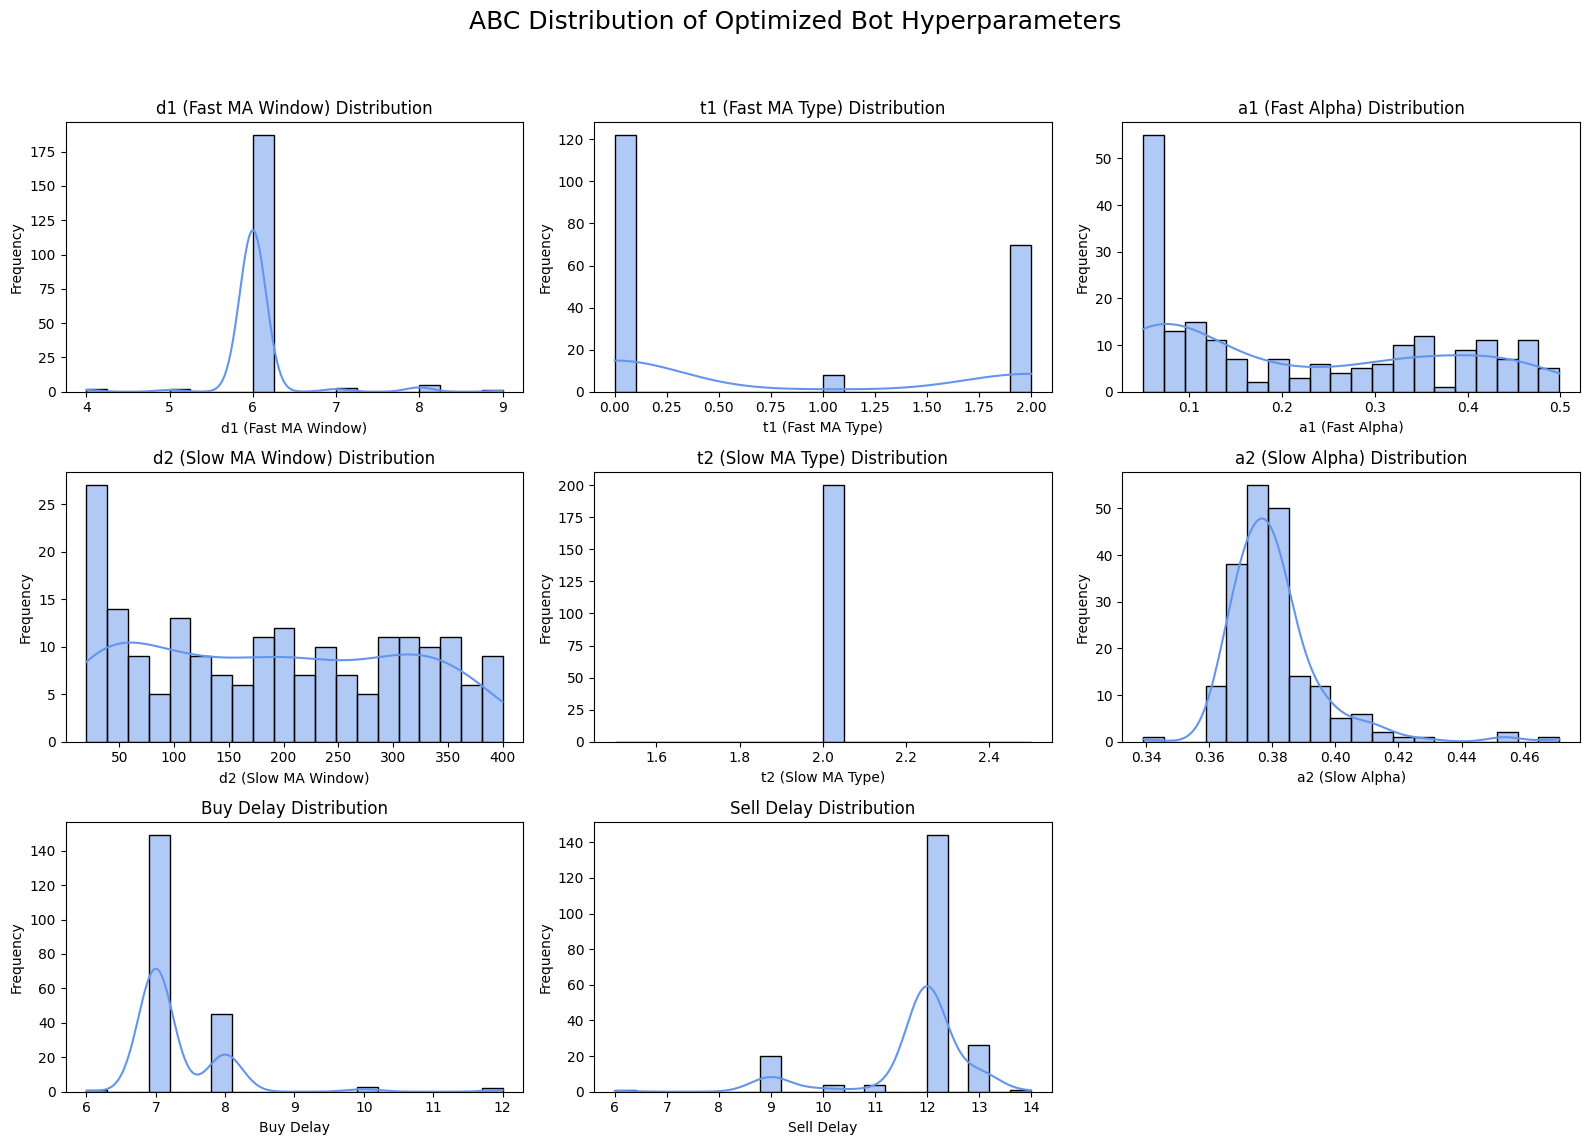

In [18]:
plot_theta_distribution(best_df, alg_filter="ABC")

## 3. Advanced Metrics (WIP)

This section introduces derived metrics that go beyond simple test/train fitness scores. These insights help us better understand the optimization behavior of each algorithm run, such as how quickly it converges, how stable it is after finding its best solution, and how efficiently it improves over time.

We compute the following metrics:

| Metric                            | Description                                                                                   |
| --------------------------------- | --------------------------------------------------------------------------------------------- |
| **best\_gen**                     | Generation where the best fitness value (lowest) was found.                                   |
| **final\_fitness**                | Fitness value in the final generation (lower is better).                                      |
| **test**                          | Final test set fitness (used for ranking and comparison).                                     |
| **convergence\_delta**            | `initial - final` fitness — total improvement across the run.                                 |
| **convergence\_speed**            | Generation index where fitness change first drops below the tolerance threshold.              |
| **generalisation\_gap**           | `train - test` fitness difference — lower means better generalisation.                        |
| **generalisation\_gap\_per\_day** | Train-test gap normalized by days — accounts for different data durations.                    |
| **abs\_gap\_per\_day**            | Absolute value of per-day generalisation gap — removes direction to highlight severity.       |
| **gap\_pct**                      | Generalisation gap as a percentage of initial capital (e.g. from \$1000 start).               |
| **abs\_gap\_pct**                 | Absolute percentage gap — for comparing severity regardless of direction.                     |
| **monotonicity\_ratio**           | Fraction of generations where fitness improved from the previous generation.                  |
| **gain\_per\_gen**                | Average rate of improvement per generation — higher is better (lower final fitness faster).   |
| **tail\_stability**               | Standard deviation of fitness values *after* the best solution was found — lower is steadier. |
| **stalled\_correct**              | Boolean: Did early stopping happen *after* the best fitness was already found?                |
| **runtime(s)**                    | Total runtime of the optimization run, in seconds.                                            |



These metrics enable analysis like:

- Which algorithms converge faster or are more monotonic?

- Do some optimizers overfit (high generalisation gap)?

- Are early stopping criteria behaving correctly?

### 3.1 Compute Advanced Metrics (WIP)

In [43]:
def compute_advanced_metrics(df, tolerance_col="tolerance", patience_col="patience"):
    """
    Compute advanced metrics for each row in a results DataFrame.

    Parameters:
        df (pd.DataFrame): DataFrame with columns including 'fitness_history', 'train', 'test', 'time(seconds)', etc.

    Returns:
        pd.DataFrame: A new DataFrame with advanced insight columns appended.
    """
    metrics = []

    for _, row in df.iterrows():
        # Parse fitness history
        history = row["fitness_history"]
        if isinstance(history, str):
            history = ast.literal_eval(history)
        history = np.array(history)

        # Basic metrics
        convergence_delta = history[0] - history[-1]
        best_gen = int(np.argmin(history))
        num_gens = len(history)
        if patience_col in row.index and best_gen is not None:
            stalled_correct = row["gens"] <= best_gen + row[patience_col]
        else:
            stalled_correct = np.nan
        time_sec = row.get("time(seconds)", np.nan)

        # Generalisation
        generalisation_gap = row["train"] - row["test"]
        # Per day
        train_days = len(prices_train)
        test_days = len(prices_test)
        generalisation_gap_per_day = (row["train"] / train_days) - (row["test"] / test_days)
        abs_gap_per_day = abs(generalisation_gap_per_day)

        # Percentage
        start_balance = 1000
        gap_pct = (row["train"] - row["test"]) / start_balance
        abs_gap_pct = abs(gap_pct)

        # Fitness gain per generation
        gain_per_gen = convergence_delta / num_gens if num_gens else np.nan

        # Monotonicity score
        improvements = np.sum(np.diff(history) < 0)
        monotonicity_ratio = improvements / (len(history) - 1)

        # Convergence speed (gen where improvement slows)
        diffs = np.abs(np.diff(history))
        tol = row.get(tolerance_col, 1e-6)
        try:
            convergence_speed = int(np.argmax(diffs < tol))
        except:
            convergence_speed = np.nan

        # Post-best stability
        tail_stability = np.std(history[best_gen:]) if best_gen < len(history) else np.nan

        metrics.append({
            "alg": row["alg"],
            "seed": row["seed"],
            "best_gen": best_gen,
            "final_fitness": history[-1],
            "test": row["test"],
            "convergence_delta": convergence_delta,
            "convergence_speed": convergence_speed,
            "generalisation_gap": generalisation_gap,
            "generalisation_gap_per_day": generalisation_gap_per_day,
            "abs_gap_per_day": abs_gap_per_day,
            "abs_gap_pct": abs_gap_pct,
            "gap_pct": gap_pct,
            "monotonicity_ratio": monotonicity_ratio,
            "gain_per_gen": gain_per_gen,
            "tail_stability": tail_stability,
            "stalled_correct": stalled_correct,
            "runtime(s)": time_sec
        })

    df = pd.DataFrame(metrics)
    df["is_best"] = df.groupby("alg")["test"].transform("min") == df["test"]
    return df.sort_values(by=["alg", "test"]).reset_index(drop=True)

def plot_radar_chart(df, alg_column="alg", metrics=None, normalize=True, alg_list=None):
    """
    Plot a radar/spider chart comparing the mean metric values for each algorithm.

    Parameters:
        df (pd.DataFrame): DataFrame containing algorithm and metric columns.
        alg_column (str): Name of the column containing algorithm names.
        metrics (list): List of metric columns to include. If None, select all numeric columns.
        normalize (bool): Whether to normalize metrics (0-1 scale).
        alg_list (list): Optional list of specific algorithm names to plot.
    """
    if metrics is None:
        metrics = df.select_dtypes(include=[np.number]).columns.difference([alg_column]).tolist()

    # Compute mean of each metric per algorithm
    plot_data = df.groupby(alg_column)[metrics].mean().reset_index()

    # Filter if specific algorithms are provided
    if alg_list:
        plot_data = plot_data[plot_data[alg_column].isin(alg_list)]

    # Normalize the metrics
    if normalize:
        scaler = MinMaxScaler()
        plot_data[metrics] = scaler.fit_transform(plot_data[metrics])

    # Setup radar axes
    categories = metrics
    N = len(categories)
    angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()
    angles += angles[:1]  # close the loop

    plt.figure(figsize=(9, 9))
    ax = plt.subplot(111, polar=True)

    for _, row in plot_data.iterrows():
        values = row[metrics].tolist()
        values += values[:1]
        label = row[alg_column]
        ax.plot(angles, values, label=label)
        ax.fill(angles, values, alpha=0.1)

    ax.set_title("Radar Chart: Mean Metric Comparison per Algorithm", y=1.1)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories, fontsize=10)
    ax.set_yticks([0.2, 0.5, 0.8])
    ax.set_yticklabels(["0.2", "0.5", "0.8"])
    ax.grid(True)
    ax.legend(loc="upper right", bbox_to_anchor=(1.3, 1.1), fontsize=9)
    plt.tight_layout()
    plt.show()



In [44]:
advanced_metrics_df = compute_advanced_metrics(best_df)
display(advanced_metrics_df.head())

,alg,seed,best_gen,final_fitness,test,convergence_delta,convergence_speed,generalisation_gap,generalisation_gap_per_day,abs_gap_per_day,abs_gap_pct,gap_pct,monotonicity_ratio,gain_per_gen,tail_stability,stalled_correct,runtime(s),is_best
0,ABC,3700,2,-62523.399028,-9090.518801,9415.947813,2,-53432.880226,-22.122292,22.122292,53.432880,-53.432880,0.166667,724.303678,7.275958e-12,False,3.41,True
1,ABC,3676,5,-59095.943805,-9057.542472,41260.751988,1,-50038.401333,-20.321264,20.321264,50.038401,-50.038401,0.133333,2578.796999,7.275958e-12,False,5.34,False
2,ABC,3824,10,-59095.943805,-9057.542472,1173.300353,0,-50038.401333,-20.321264,20.321264,50.038401,-50.038401,0.050000,55.871445,7.275958e-12,False,5.01,False
3,ABC,962,5,-56382.460376,-8715.674840,46552.191028,5,-47666.785535,-19.294598,19.294598,47.666786,-47.666786,0.333333,2909.511939,7.275958e-12,False,4.10,False
4,ABC,830,10,-53961.666296,-8684.058276,46173.439026,2,-45277.608019,-18.033067,18.033067,45.277608,-45.277608,0.200000,2198.735192,7.275958e-12,False,5.90,False


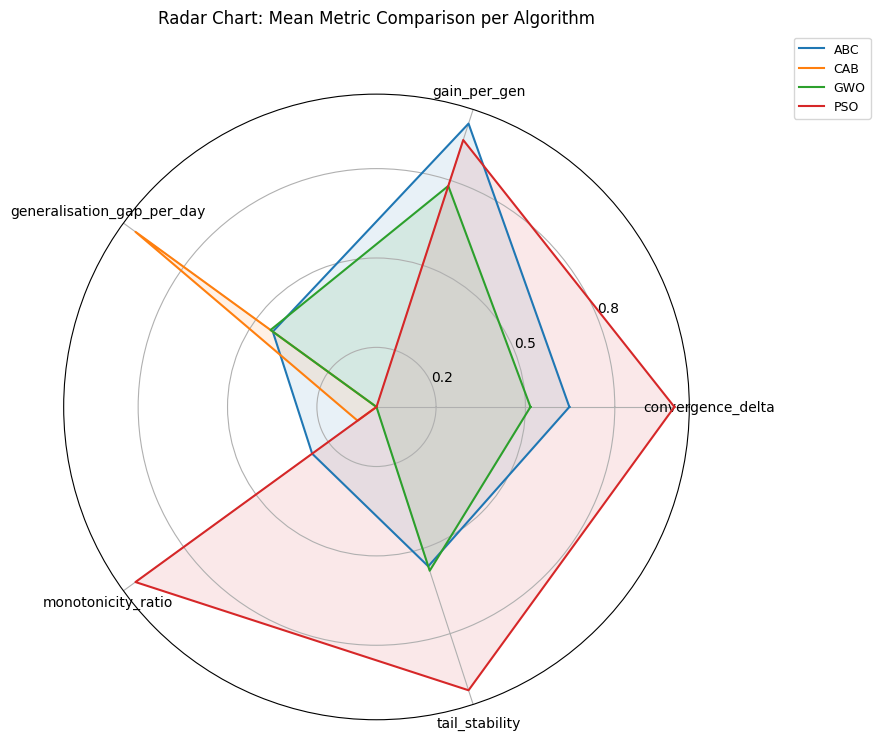

In [45]:
metrics_to_plot = [
    "convergence_delta",
    "gain_per_gen",
    "generalisation_gap_per_day",
    "monotonicity_ratio",
    "tail_stability"
]

plot_radar_chart(
    df=advanced_metrics_df,              
    metrics=metrics_to_plot,
)

### 3.2 Optimizer Behavior & Convergence Characteristics

In this section, we explore how each optimizer behaves across several key metrics:

1. Fitness Gain per Second vs. Generalisation Gap

    Reveals whether an optimizer is both fast and generalizable, or if it's simply overfitting the training data.

2. Convergence Speed

    Measures how many generations it takes for the optimizer to plateau. Lower is better.

3. Monotonicity Ratio

    Assesses whether the optimizer consistently improves or fluctuates during search.

4. Convergence Delta

    Represents the total improvement achieved during training — useful for spotting ineffective optimizers.

Each of these visualizations helps identify which algorithms are stable, efficient, or prone to overfitting or instability.

In [46]:
def plot_advanced_insights(df):
    """
    Create visualizations from advanced optimizer metrics DataFrame.
    Includes:
    - Scatter plot of gain_per_sec vs generalisation_gap
    - Boxplots of convergence speed and monotonicity ratio
    - Bar plot of convergence delta
    """
 # Scatter plot: Efficiency vs Generalisation
    # | Axis        | What it Represents                                             |
    # |-------------|----------------------------------------------------------------|
    # | **X-axis**  | **Fitness Gain per Generation** (`gain_per_gen`)              |
    # |             | → Measures how *efficiently* the optimizer improves per gen   |
    # | **Y-axis**  | **Generalisation Gap** (`train - test`)                        |
    # |             | → Measures *overfitting* or *underfitting*                    |
    # | Plot Region         | What it Suggests                                       |
    # |---------------------|--------------------------------------------------------|
    # | **Top Right**       | Fast optimizer, but **overfits** to training data      |
    # | **Bottom Right**    | Fast & **well-generalized** (ideal)                    |
    # | **Top Left**        | Slow but overfits (not useful)                         |
    # | **Bottom Left**     | Slow but generalizes well (safe but inefficient)       |

    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df, x="gain_per_gen", y="generalisation_gap", hue="alg", style="alg", s=100)
    plt.axhline(0, linestyle="--", color="grey", alpha=0.5)
    plt.title("Optimization Efficiency vs Generalisation Gap")
    plt.xlabel("Fitness Gain per Generation")
    plt.ylabel("Generalisation Gap (Train - Test)")
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.tight_layout()
    plt.show()

    # Boxplot: Convergence Speed
    # | Position on Y-axis | What It Means                                |
    # |--------------------|-----------------------------------------------|
    # | Lower box (shorter time) | Algorithm converges faster (desirable)  |
    # | Wider box           | High variability in convergence speed        |
    # | High outliers       | Some runs took a long time to stabilize      |
    # Each box shows the distribution of convergence speeds for an algorithm across multiple runs.

    # You’ll see:
    #     Median line inside the box
    #     Interquartile range (IQR) (box height)
    #     Whiskers show the spread
    #     Outliers (dots) indicate unstable or slow convergence
    plt.figure(figsize=(8, 5))
    sns.boxplot(data=df, x="alg", y="convergence_speed", hue="alg", palette="Set2", showfliers=False, legend=False)
    plt.title("Convergence Speed per Algorithm")
    plt.ylabel("Generations to Plateau")
    plt.grid(True, axis='y', linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()

    # Boxplot: Monotonicity Ratio
    # | Value           | Interpretation                            |
    # |-----------------|--------------------------------------------|
    # | **Close to 1.0** | Optimizer **consistently improves**       |
    # | **~0.5**         | Fitness goes up and down equally          |
    # | **Close to 0.0** | Optimizer mostly deteriorates or stalls   |
    # A high monotonicity algorithm steadily climbs toward a good solution
    # A low score may indicate instability, oscillation, or poor search direction
    plt.figure(figsize=(8, 5))
    sns.boxplot(data=df, x="alg", y="monotonicity_ratio", hue="alg", palette="Set3", showfliers=False, legend=False)
    plt.title("Monotonicity Ratio per Algorithm")
    plt.ylabel("Fraction of Improving Generations")
    plt.grid(True, axis='y', linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()

    # Bar Plot: Convergence Delta
    # | High Delta        | Low Delta              |
    # |-------------------|------------------------|
    # | Big improvement   | Little or no progress  |
    # | Good exploration  | Stalled or poor tuning |
    # | Effective optimizer | Ineffective optimizer |
    # Each bar = one algorithm
    # Taller bars = greater total improvement
    # Useful for:
    #     Comparing how effective optimizers were across runs
    #     Showing which ones are just “spinning their wheels” without results 
    plt.figure(figsize=(10, 6))
    sns.barplot(data=df, x="alg", y="convergence_delta", hue="alg", errorbar=None, palette="pastel", legend=False)
    plt.title("Convergence Delta per Algorithm")
    plt.ylabel("Initial - Final Fitness")
    plt.grid(True, axis='y', linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()


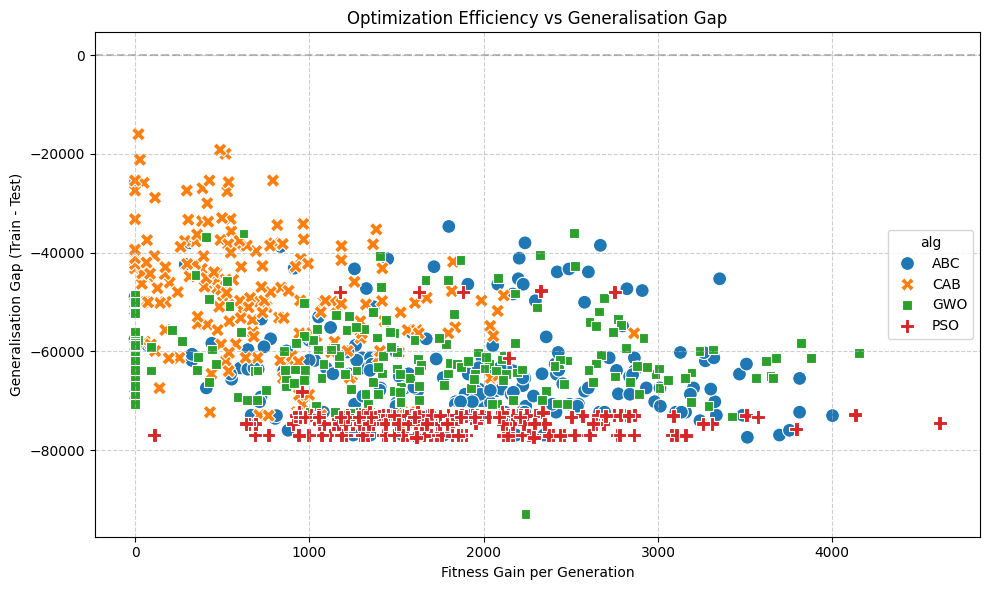

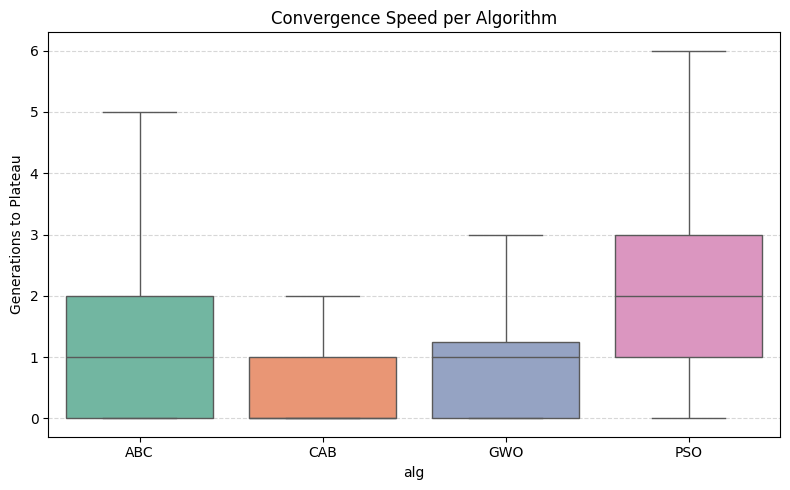

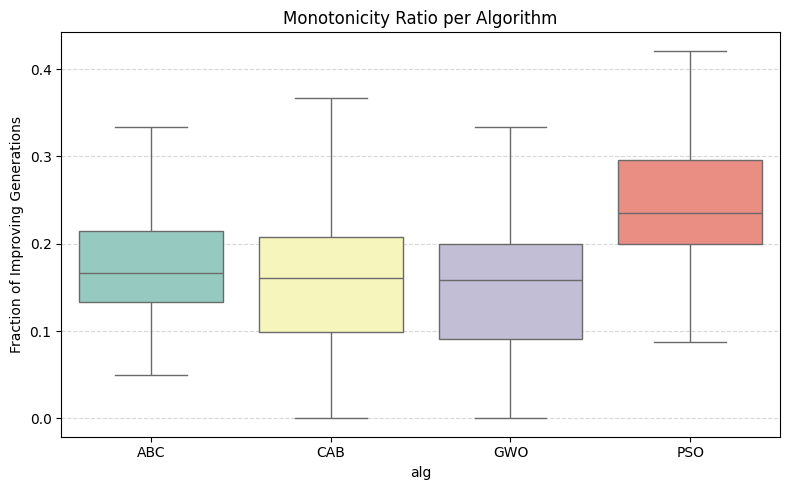

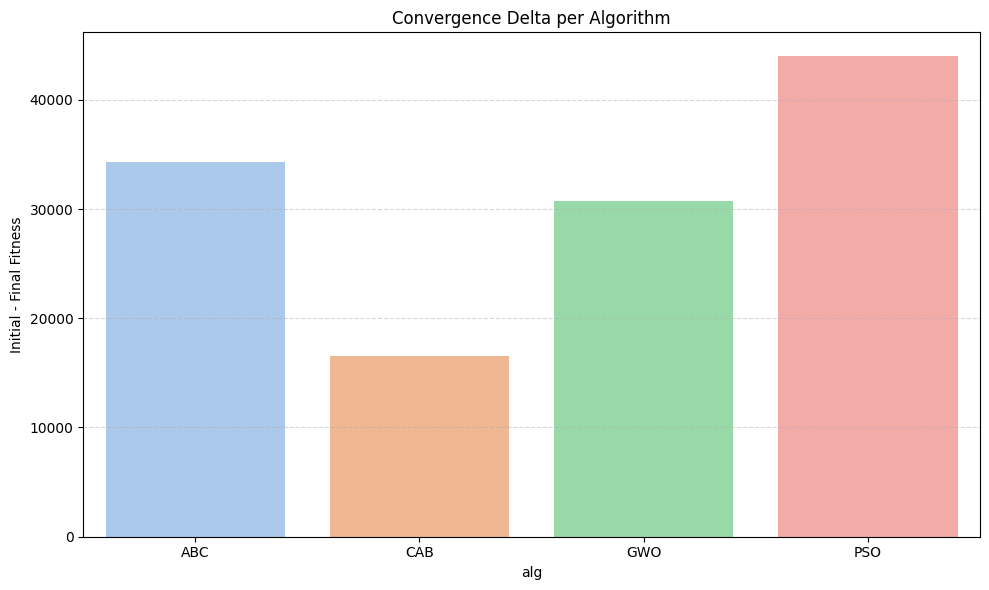

In [47]:
plot_advanced_insights(advanced_metrics_df)

### 3.3 Generalisation Gap Analysis

| Metric            | What it Shows                                          | Best Value |
| ----------------- | ------------------------------------------------------ | ---------- |
| `abs_gap_per_day` | Average daily overfit/underfit distance                | Close to 0 |
| `abs_gap_pct`     | Relative to initial capital (impact of generalisation) | Close to 0 |


In [38]:
def plot_generalisation_gap_comparison(df):
    """
    Compare absolute generalisation gap metrics:
    - abs_gap_per_day: normalized by time duration
    - abs_gap_pct: normalized by initial balance (percentage)

    Args:
        df (pd.DataFrame): Must contain 'alg', 'abs_gap_per_day', and 'abs_gap_pct'.
    """
    # Prepare data in long format for side-by-side plotting
    long_df = pd.melt(
        df,
        id_vars="alg",
        value_vars=["abs_gap_per_day", "abs_gap_pct"],
        var_name="Metric",
        value_name="Value"
    )

    plt.figure(figsize=(12, 6))
    sns.boxplot(data=long_df, x="alg", y="Value", hue="Metric", palette="Set2")
    plt.title("Comparison of Absolute Generalisation Gaps by Algorithm")
    plt.ylabel("Gap Value")
    plt.xlabel("Algorithm")
    plt.legend(title="Metric")
    plt.grid(axis="y", linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()

def plot_generalisation_gap_comparison_enhanced(df, highlight_best=True):
    """
    Enhanced side-by-side comparison of generalisation gap metrics with strip overlays.

    Parameters:
        df (pd.DataFrame): DataFrame must include 'alg', 'abs_gap_per_day', and 'abs_gap_pct'.
        highlight_best (bool): If True, sorts algorithms by median abs_gap_pct (optional).
    """
    long_df = pd.melt(
        df,
        id_vars="alg",
        value_vars=["abs_gap_per_day", "abs_gap_pct"],
        var_name="Metric",
        value_name="Value"
    )

    if highlight_best:
        # Optional: reorder algs by median performance on abs_gap_pct
        order = (
            long_df[long_df["Metric"] == "abs_gap_pct"]
            .groupby("alg")["Value"]
            .median()
            .sort_values()
            .index.tolist()
        )
    else:
        order = sorted(df["alg"].unique())

    plt.figure(figsize=(12, 6))
    sns.boxplot(
        data=long_df,
        x="alg",
        y="Value",
        hue="Metric",
        order=order,
        palette="Set2",
        showfliers=False
    )
    sns.stripplot(
        data=long_df,
        x="alg",
        y="Value",
        hue="Metric",
        dodge=True,
        order=order,
        palette="dark:.3",
        size=4,
        alpha=0.6,
        legend=False
    )

    plt.title("Generalisation Gap Comparison by Algorithm")
    plt.ylabel("Absolute Gap")
    plt.xlabel("Algorithm")
    plt.grid(axis="y", linestyle="--", alpha=0.4)
    plt.legend(title="Metric")
    plt.tight_layout()
    plt.show()


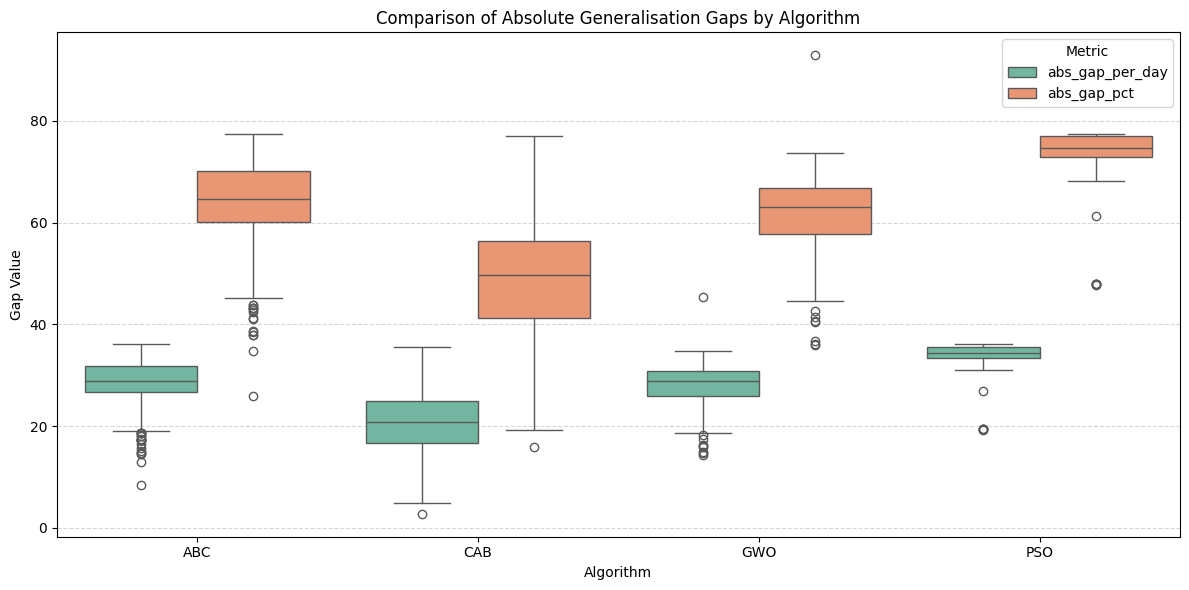

In [39]:
plot_generalisation_gap_comparison(advanced_metrics_df)

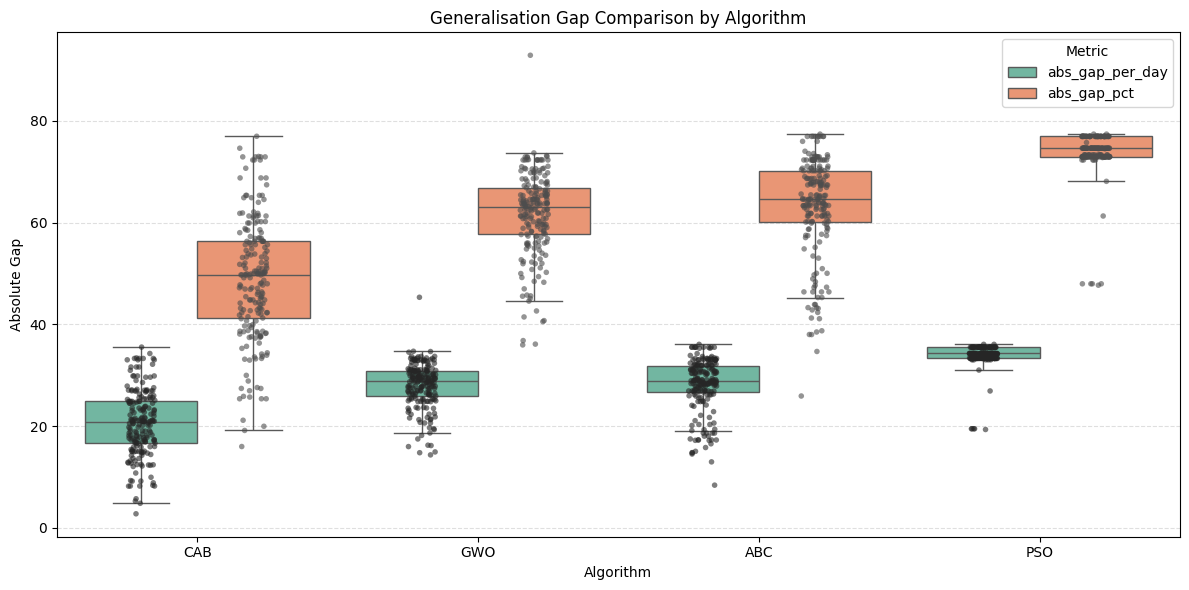

In [40]:
plot_generalisation_gap_comparison_enhanced(advanced_metrics_df)

In [54]:
# Heatmap of correlation between metrics
def plot_metric_correlation_heatmap(df, exclude_columns=["alg", "seed"]):
    metrics_df = df.drop(columns=exclude_columns, errors='ignore').select_dtypes(include='number')
    correlation = metrics_df.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
    plt.title("Correlation Heatmap of Metrics")
    plt.tight_layout()
    plt.show()

# Scatter matrix for key metrics
def plot_scatter_matrix(df, metrics, hue="alg"):
    sns.pairplot(df[metrics + [hue]], hue=hue, diag_kind="kde", corner=True)
    plt.suptitle("Scatter Matrix of Selected Metrics", y=1.02)
    plt.tight_layout()
    plt.show()

# Distribution of test fitness by algorithm
def plot_test_fitness_distribution(df):
    plt.figure(figsize=(10, 6))
    sns.violinplot(x="alg", y="test", data=df, palette="Set2", inner="box")
    plt.title("Distribution of Test Fitness per Algorithm")
    plt.ylabel("Test Fitness (Lower is Better)")
    plt.grid(True, axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()


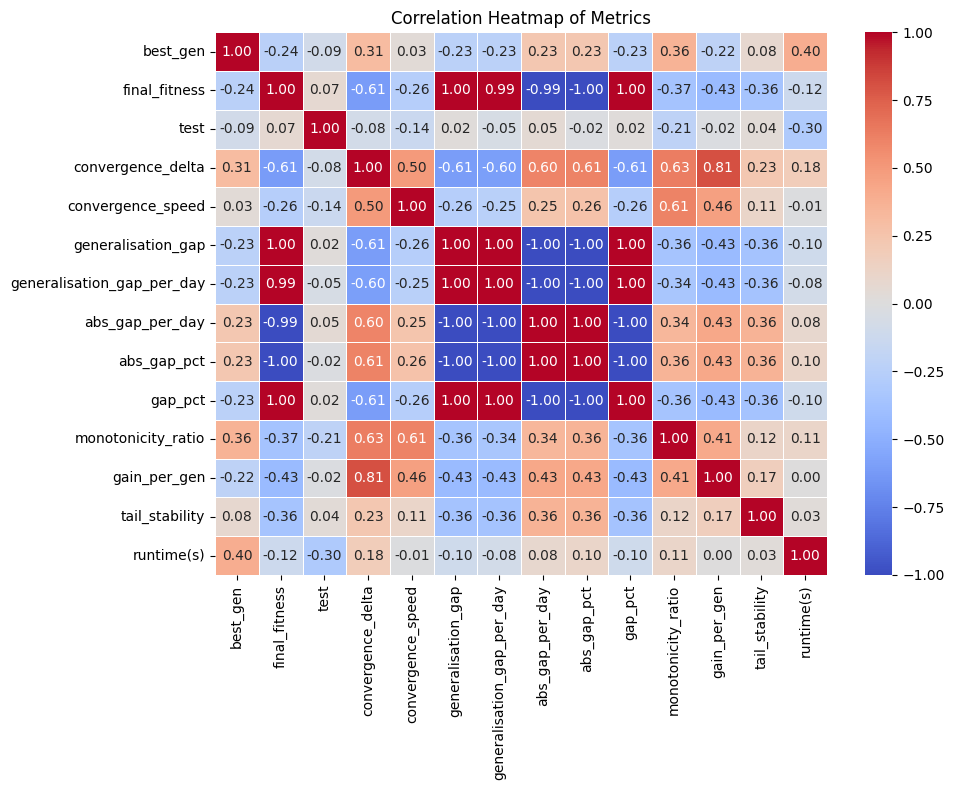

In [ ]:
plot_metric_correlation_heatmap(advanced_metrics_df)

C:\Users\thanh\AppData\Local\Temp\ipykernel_21572\2061998734.py:21: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




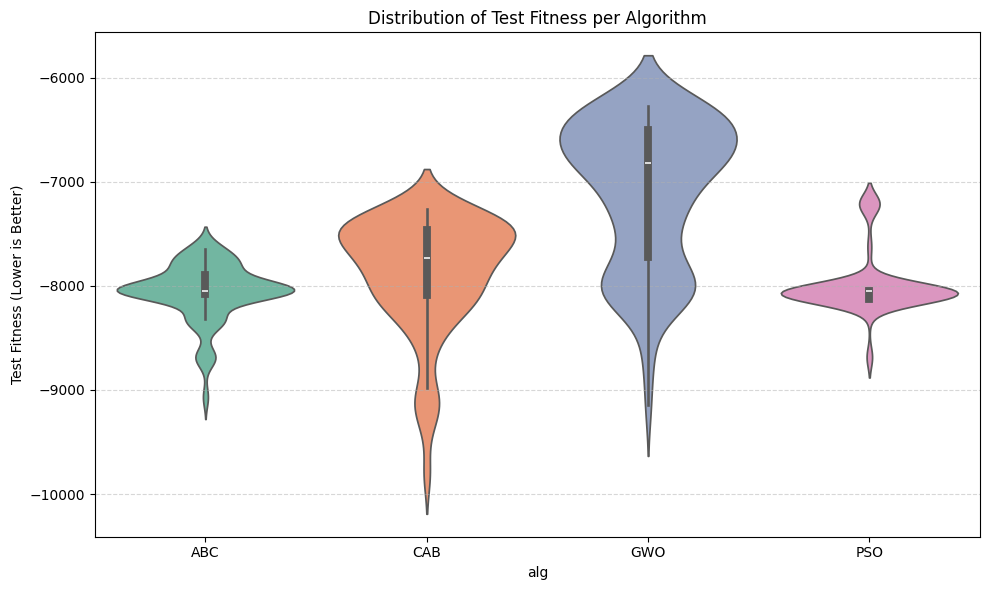

In [56]:
plot_test_fitness_distribution(advanced_metrics_df)

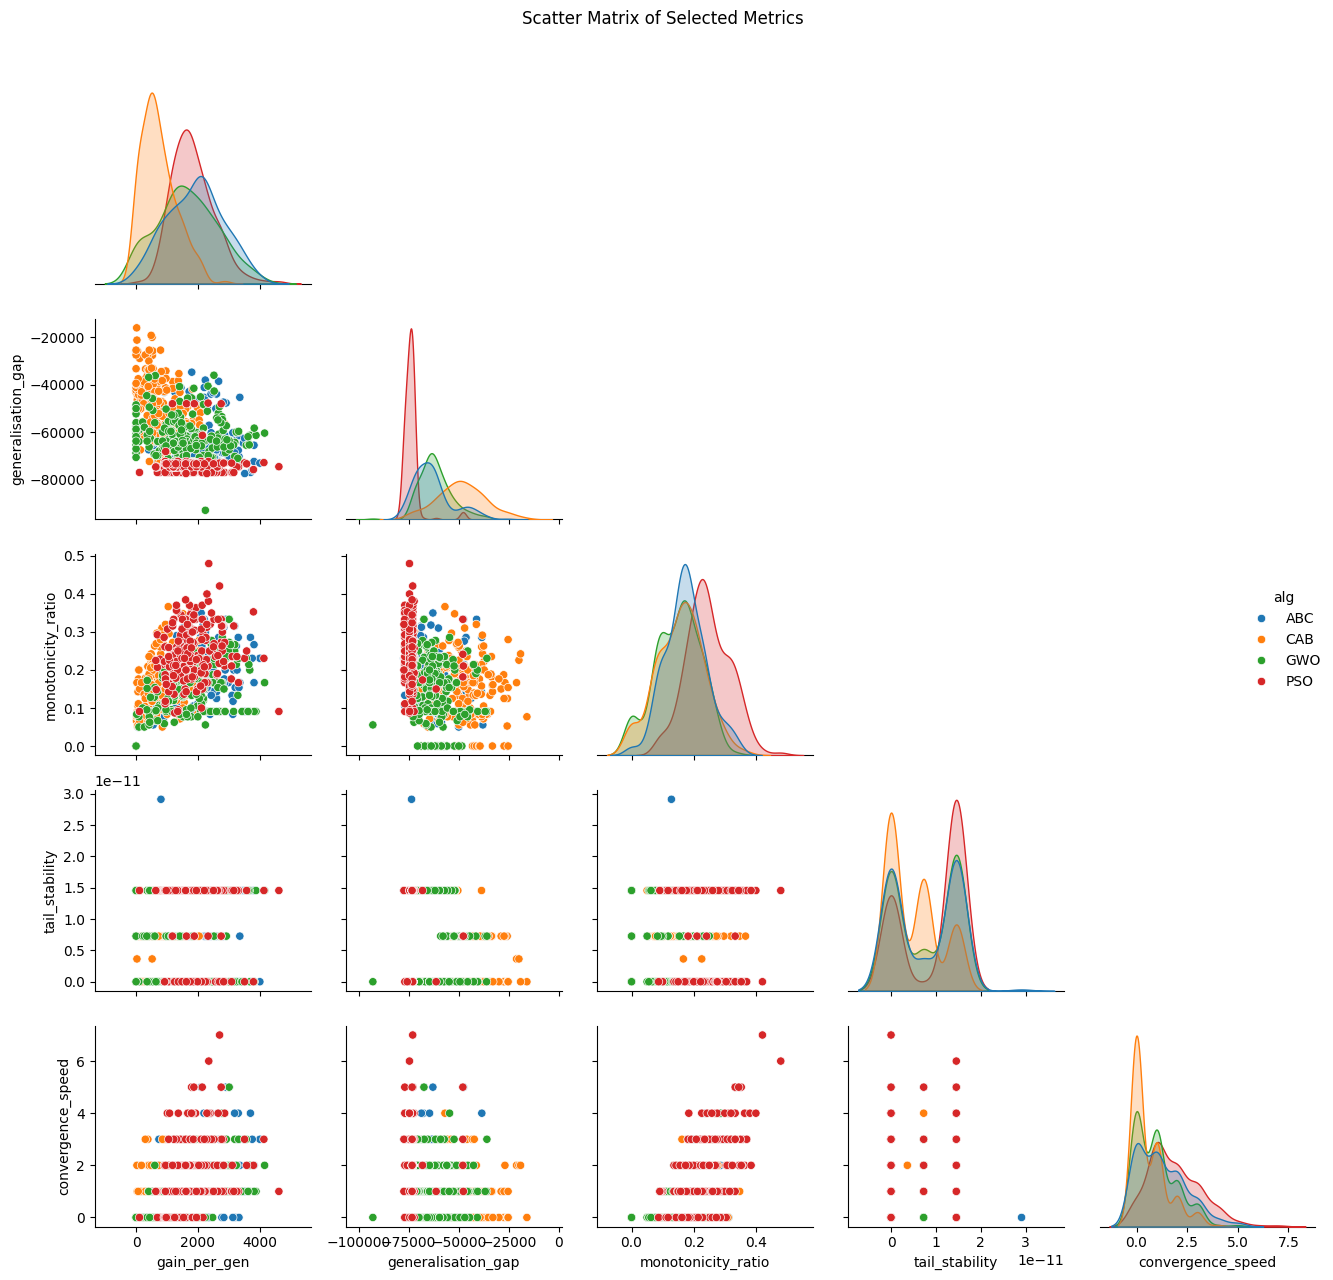

In [57]:
plot_scatter_matrix(advanced_metrics_df, metrics=["gain_per_gen", "generalisation_gap", "monotonicity_ratio", "tail_stability", "convergence_speed"])


In [74]:
def plot_tail_stability(df, metric="tail_stability", alg_filter=None):
    """
    Plot the distribution of tail stability across algorithms.

    Parameters:
        df (pd.DataFrame): DataFrame containing algorithm and tail stability metrics.
        metric (str): Column name for tail stability metric (default: 'tail_stability').
        alg_filter (str or list): Filter results to specific algorithm(s).
    """
    algo_name = "All"
    # Apply algorithm filtering if needed
    if alg_filter is not None:
        alg_filter = [alg_filter] if isinstance(alg_filter, str) else alg_filter
        df = df[df["alg"].isin(alg_filter)]
        algo_name = alg_filter[0]

    plt.figure(figsize=(10, 6))
    sns.boxplot(x="alg", y=metric, data=df, palette="Set2", hue="alg", showfliers=False, legend=False)
    sns.stripplot(x="alg", y=metric, data=df, color="black", size=5, jitter=True, alpha=0.7)

    plt.title(f"Tail Stability Distribution per Algorithm ({algo_name})")
    plt.ylabel("Tail Stability")
    plt.xlabel("Algorithm")
    plt.grid(True, axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

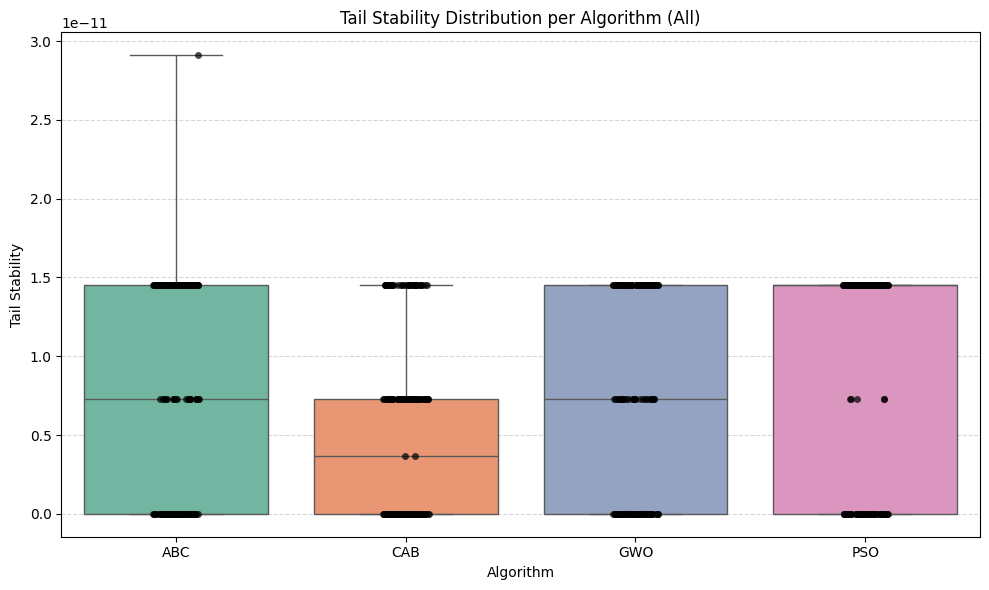

In [73]:
plot_tail_stability(advanced_metrics_df)

1) Plot average convergence curves

In [ ]:

def plot_convergence(df, max_gens=None):
    """
    Plot average convergence curves (fitness over generations) for each algorithm.
    
    Parameters:
        df (pd.DataFrame): DataFrame with 'alg' and 'fitness_history' columns.
        max_gens (int or None): Limit number of generations shown (optional).
    """
    # Dictionary to store all runs per algorithm
    algo_histories = {}

    for _, row in df.iterrows():
        alg = row['alg']
        history = ast.literal_eval(row['fitness_history'])  # convert string to list

        if max_gens:
            history = history[:max_gens]

        if alg not in algo_histories:
            algo_histories[alg] = []
        algo_histories[alg].append(history)

    plt.figure(figsize=(12, 6))
    for alg, runs in algo_histories.items():
        # Pad shorter runs if needed
        max_len = max(len(run) for run in runs)
        padded = [run + [run[-1]] * (max_len - len(run)) for run in runs]
        avg_history = np.mean(padded, axis=0)
        plt.plot(avg_history, label=alg)

    plt.title("Convergence Curves (Average Fitness per Generation)")
    plt.xlabel("Generation")
    plt.ylabel("Fitness")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


plot_convergence(best_df)


2) Average Train/Test Performance

In [ ]:
def plot_avg_train_test(df):
    avg = df.groupby('alg')[['train', 'test']].mean()
    avg.plot(kind='bar', figsize=(10, 6))
    plt.title("Average Train vs Test Fitness per Algorithm")
    plt.ylabel("Fitness")
    plt.grid(True, axis='y')
    plt.tight_layout()
    plt.show()

plot_avg_train_test(best_df)

3) Theta VS Fitness

In [ ]:


def plot_theta_vs_fitness(df, fitness_col='test'):
    """
    Plot each theta component against the fitness score (train/test).

    Parameters:
        df (pd.DataFrame): DataFrame with a 'theta_parsed' column and a fitness column.
        fitness_col (str): Either 'train' or 'test'.
    """
    theta_names = ['d1', 't1', 'a1', 'd2', 't2', 'a2', 'buy_delay', 'sell_delay']
    theta_df = pd.DataFrame(df['theta_parsed'].tolist(), columns=theta_names)
    theta_df[fitness_col] = df[fitness_col].values

    plt.figure(figsize=(16, 10))
    for i, col in enumerate(theta_names):
        plt.subplot(3, 3, i + 1)
        sns.scatterplot(x=theta_df[col], y=theta_df[fitness_col])
        plt.xlabel(col)
        plt.ylabel(fitness_col)
        plt.title(f"{fitness_col} vs {col}")
        
    
    plt.suptitle(f"Theta Parameters vs {fitness_col.capitalize()} Fitness", fontsize=18)
    plt.tight_layout(rect=[0, 0, 1, 0.95]) 
    plt.show()
    
    
plot_theta_vs_fitness(best_df, fitness_col="test")

